In [15]:
#Imports.

import matplotlib.pyplot as plt
import numpy as np
import os.path
import refnx, scipy
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain, PDF
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet, sld_profile
from refnx.dataset import ReflectDataset
import random
import tqdm
from monolayer import monolayer

seed = 1234
%matplotlib inline

In [2]:
#Load in data. 

data_d2o = ReflectDataset('54696_97_d2o.txt')
data_pmw = ReflectDataset('54699_00_pmw.txt')

#Materials (Scattering Length Density)

d2o_sld = Parameter(6.2, 'd2o SLD', vary=True, bounds= (6,6.35))
pmw_sld = Parameter(2.2, 'pmw SLD', vary=True, bounds= (2,3))
h2o_sld = Parameter(-0.56, 'h2o SLD', vary=True, bounds= (-1,1))

d2o = SLD(d2o_sld, name = 'D2O') #D2O
pmw = SLD(pmw_sld, name = 'PMW') #PMW
air = SLD(0) #Air
h2o = SLD(h2o_sld) #Water


In [3]:
#Area Per Molecule 

apm = Parameter(60, 'area per molecule', vary=True, bounds=(57, 62))

#Head and tail group thicknesses and roughness.

head_thickness = Parameter(7.92, 'head_thickness', vary=True, bounds=(5.52, 15))
tail_thickness = Parameter(17.99, 'tail_thickness', vary=True, bounds=(13.67, 20.5))
roughness = Parameter(4, 'roughness', vary=True, bounds=(3.3, 10))
solv_rough = Parameter(4, 'solv rough', vary = True, bounds = (3.3,10))

#D2O slab
d2o_slab = d2o(0, roughness)
d2o_top = d2o(5, roughness)
d2o_top.thick.setp(5, vary = True, bounds = (5,10))

#PMW slab
pmw_slab = pmw(0, roughness)
pmw_top = pmw(5, roughness)
pmw_top.thick.setp(5, vary = True, bounds = (3,10))


In [4]:
#Define all the neutron b's
bc = 0.6646e-4;	
bo = 0.5804e-4;	
bh = -0.3739e-4;
bp = 0.513e-4
bn = 0.936e-4
bd = 0.6671e-4

#Formulae of the molecule sections
CH2 = (1*bc) + (2*bh);
CH = (1*bc) + (1*bh);
CH3 = (1*bc) + (3*bh);
D2O = (2*bd) + (1*bo);
H2O = (2*bh) + (1*bo);


In [5]:
#Bilayer

sum_b_tails = (28*CH2) + (2*CH) + (2*CH3) 
sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
sum_b_heads = (1/4)*(3*(sum_popc_heads) + (sum_popg_heads)) 

vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
volume_tails = (nCH2 * vCH2) + (2 * vCH3)
volume_heads = 331

#Monolayer

sum_m_tails = (34*CH2) + (2*CH3)
sum_m_heads = (1*bn) + (2*CH3)

volume_m_tails = vCH2*36
volume_m_heads = 54.6



In [6]:
#Sum of scattering lengths for the lipid head and tail in Angstrom.

b_heads = Parameter(sum_b_heads, 'b_heads')
b_tails = Parameter(sum_b_tails, 'b_tails')

#Volume occupied by the head and tail groups in cubic Angstrom.

v_heads = Parameter(volume_heads, 'v_heads')
v_tails = Parameter(volume_tails, 'v_tails')

#Bilayer

bilayer_top = LipidLeaflet(apm,
                             b_heads, v_heads, head_thickness,
                             b_tails, v_tails, tail_thickness,
                             roughness, roughness, head_solvent = d2o)

bilayer_bottom = LipidLeaflet(apm,
                             b_heads, v_heads, head_thickness,
                             b_tails, v_tails, tail_thickness, 
                             roughness, roughness, head_solvent = d2o, reverse_monolayer=True)

bilayer_topPMW = LipidLeaflet(apm,
                             b_heads, v_heads, head_thickness,
                             b_tails, v_tails, tail_thickness,
                             roughness, roughness, head_solvent = pmw)

bilayer_bottomPMW = LipidLeaflet(apm,
                             b_heads, v_heads, head_thickness,
                             b_tails, v_tails, tail_thickness, 
                             roughness, roughness, head_solvent = pmw, reverse_monolayer=True)



In [7]:
#Bilayer in D2O
struct_d2o = air | d2o_top | bilayer_top | bilayer_bottom | d2o_slab
 
#Bilayer in PMW
struct_pmw = air | pmw_top | bilayer_topPMW | bilayer_bottomPMW | pmw_slab

scaleargs = dict(value = 0.7675, vary=True, bounds=(0.6, 0.8))
bkgargs = dict(value = 1.5e-6, vary=True, bounds=(1e-6, 5e-6))

model_d2o = ReflectModel(struct_d2o)
model_d2o.scale.setp(**scaleargs)
model_d2o.bkg.setp(value = 2.45e-6, vary=False)

model_pmw = ReflectModel(struct_pmw)
model_pmw.scale.setp(**scaleargs)
model_pmw.bkg.setp(value = 3.7e-6, vary=False)

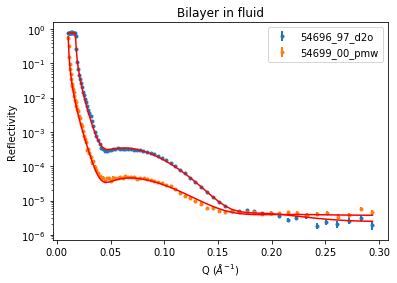

In [8]:
obj_d2o = Objective(model_d2o, data_d2o)
obj_pmw = Objective(model_pmw, data_pmw)
global_obj = GlobalObjective([obj_d2o, obj_pmw])

fitter = CurveFitter(global_obj)
fitter.fit('differential_evolution')

global_obj.plot()
plt.title('Bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.legend();

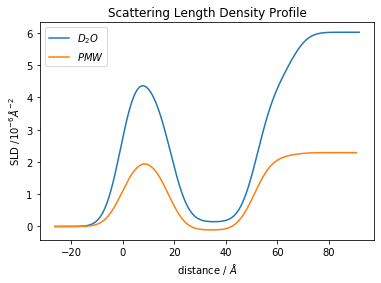

In [9]:
#SLD profile of structure.

plt.plot(*struct_d2o.sld_profile(), label = '$D_2O$')
plt.plot(*struct_pmw.sld_profile(), label = '$PMW$')
plt.title('Scattering Length Density Profile')
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.legend()
plt.savefig('SLD_oneRough.png');

In [10]:
print(global_obj.parameters)

________________________________________________________________________________
Parameters: 'global fitting parameters'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.783566 +/- 0.00192, bounds=[0.6, 0.8]>
<Parameter:     'bkg'     , value=2.45e-06 (fixed)  , bounds=[-inf, inf]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - sld'    , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' -

In [11]:
#Sample 1000 taking every 50th approximation.
fitter.sample(500, nthin = 10, random_state = seed)

#Discard first 200 samples.
process_chain(global_obj, fitter.chain, nburn = 200, flatchain=True);

100%|██████████| 5000/5000 [1:02:06<00:00,  1.34it/s]


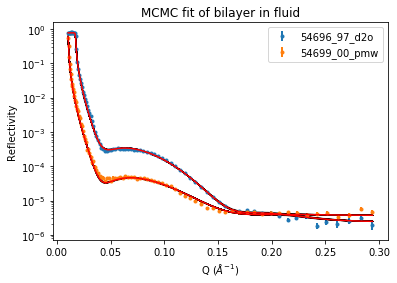

In [12]:
global_obj.plot(samples = 300)
plt.title('MCMC fit of bilayer in fluid')
plt.yscale('log')
plt.xlabel('Q $(\AA^{-1})$')
plt.ylabel('Reflectivity')
plt.savefig('MCFit.png')
plt.legend();

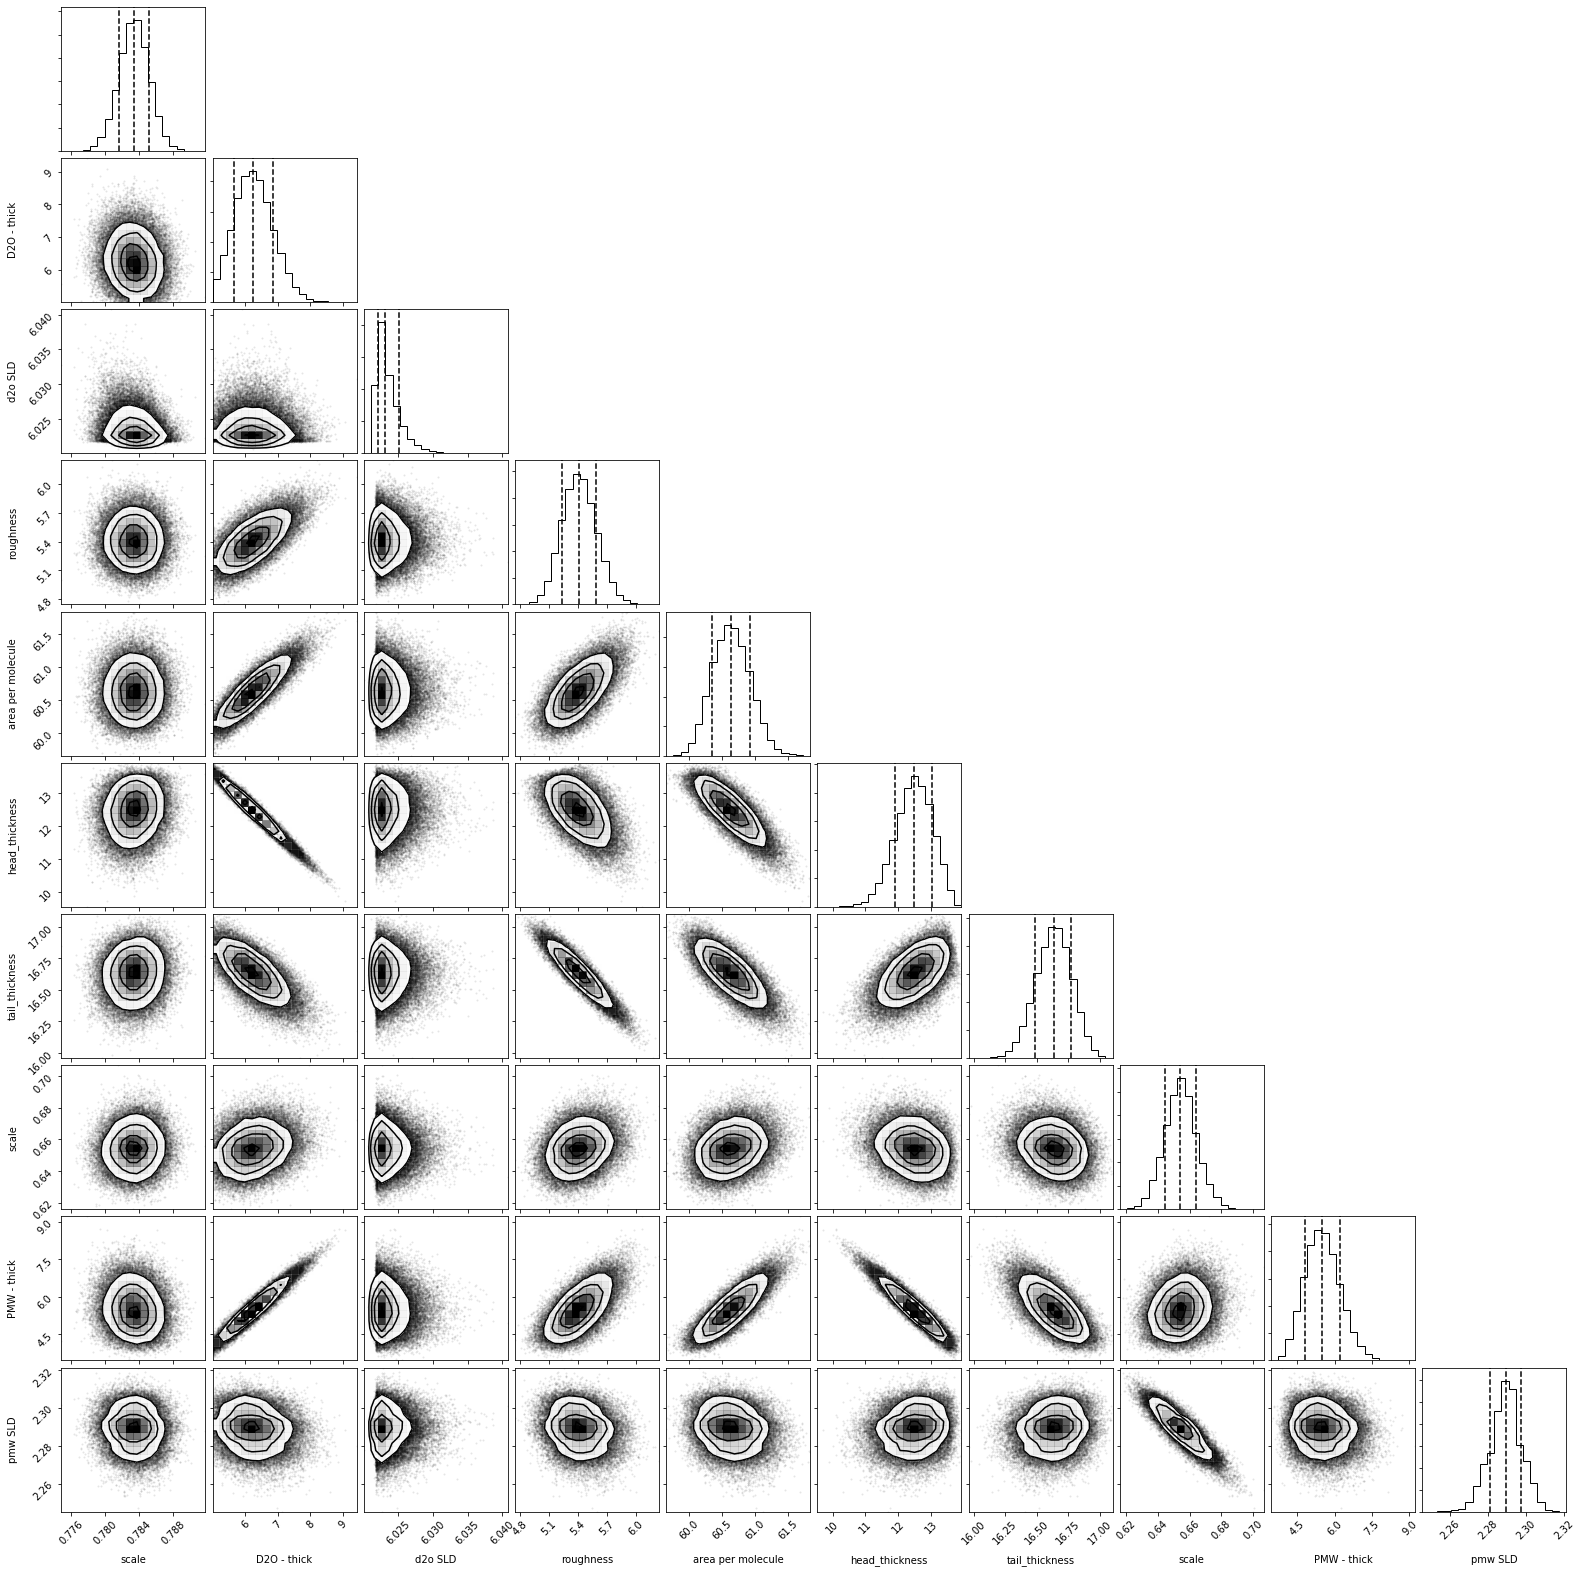

In [13]:
#Plot parameter correlations.
global_obj.corner();
plt.savefig('corrSingleRough.png');

/Users/Miron/miniconda3/envs/refnx/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


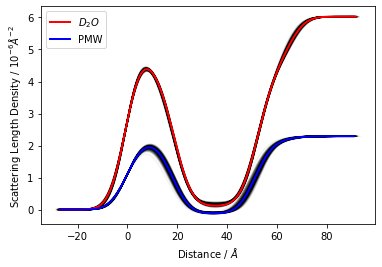

In [27]:
#Compare SLD profiles.
zD2O, median_sldD2O = struct_d2o.sld_profile()
zPMW, median_sldPMW = struct_pmw.sld_profile()

for pvec1 in obj_d2o.pgen(ngen=300):
    obj_d2o.setp(pvec1)
    zs1, sld1 = struct_d2o.sld_profile()
    plt.plot(zs1, sld1, color='k', alpha=0.05)
    
for pvec in obj_pmw.pgen(ngen=300):
    obj_pmw.setp(pvec)
    zs, sld = struct_pmw.sld_profile()
    plt.plot(zs, sld, color='k', alpha=0.05)
    
plt.plot(zD2O, median_sldD2O, lw=2, color='r', label = '$D_2O$')
plt.plot(zPMW, median_sldPMW, lw=2, color='b', label = 'PMW')
plt.ylabel('Scattering Length Density / $10^{-6}\AA^{-2}$')
plt.xlabel('Distance / $\AA$')
plt.legend()
plt.savefig('sldMCMC.png');

In [29]:
print(global_obj.parameters);

________________________________________________________________________________
Parameters: 'global fitting parameters'
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.673321 +/- 0.00178, bounds=[0.6, 0.8]>
<Parameter:     'bkg'     , value=3.7e-06 (fixed)  , bounds=[-inf, inf]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - sld'    , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - 

In [18]:
headThick = head_thickness.value
tailThick = tail_thickness.value

frac = 1 - ((tailThick*v_heads.value)/(v_tails.value*headThick))
Water = (frac*v_heads.value)/(29.9*(1 - frac))

print('Solvent fraction: {:.5f}\nWaters per head: {:.0f}'.format(frac, Water))

Solvent fraction: 0.53208
Waters per head: 13


In [33]:
global_obj.logl()

-109282.07464661285

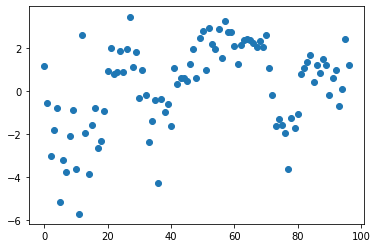

In [47]:
#Residual plot.
plt.scatter([x for x in range (len(global_obj.residuals()[75:]))], global_obj.residuals()[75:]);

In [55]:
fitter.chain[0].shape

(200, 10)

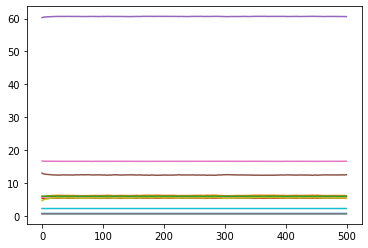

In [56]:
#Shapiro-Wilk test.
from scipy.stats import shapiro
chain = fitter.chain

temp2 = []
for param in range (chain.shape[2]):
    temp1 = []
    for sample in range(chain.shape[0]):    
        temp = []
        for val in range (chain.shape[1]):
            temp.append(chain[sample][val][param])
        temp1.append(np.mean(temp))
    temp2.append(temp1)

test = []

for dist in temp2:
    plt.plot(dist)
    test.append(shapiro(dist))

In [57]:
test

[(0.9972838759422302, 0.5859041213989258),
 (0.8843766450881958, 6.832778108447674e-19),
 (0.7572888135910034, 1.7930984020484526e-26),
 (0.9980344176292419, 0.8399956822395325),
 (0.696800172328949, 5.152294731767128e-29),
 (0.7990039587020874, 2.0472530045209277e-24),
 (0.915461003780365, 4.227632495788043e-16),
 (0.9933419823646545, 0.026291433721780777),
 (0.7068103551864624, 1.268710563836845e-28),
 (0.9860817790031433, 0.00010327805648557842)]